## Problem Statement

Reference: DataCamp mini project

Tactile Entertainment is game company that developed Cookie Cats, a popular mobile puzzle game. Its a game where the player must connect tiles of the same color to clear the board and win the level.

In the game, players will naturally go through different levels, wherein they will sometimes encounter gates that will force them to make an in-app purchase to progress.

The problem the company is having is that they don't know where to place the gates in the game. At the start, they placed the gate at level 30, and now they're thinking of changing it to level 40 instead. With this decision, they are wary of how it will affect their player retention. In addition, they would also like to see if moving the gate further will result to players playing more rounds.

\
### Success Metrics
Player retention is a good indicator that players are staying even if the gate gets moved.

The data includes 1 day retention and 7 day retention. We will be looking at both average retentions to see if there is a difference with the placement of the gate.

Aside from this, let's also look at the average game rounds per user for both levels to be extra 😙

\
### Hypothesis Formulation
Null Hypothesis (Ho): The average player retention between the level 30 and level 40 gate placements are the same

Alternative Hypothesis (Ha): The average player retention between the level 30 and level 40 gate placements are different

For our significance level, we'll be using alpha = 0.05.

Our Power level will be 0.80. This means that the probability of finding a difference when there is one is 80%

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [18]:
df.shape

(90189, 5)

So we have data from 90,189 players that were part of the experiment.

- userid - refers to the id of the user
- version - gate_30 is the control group and gate_40 is the treatment group
- sum_gamerounds - the number of rounds that player has played throughout the experiment
- retention_1 - did the player come back and play 1 day after installing
- retention_7 - did the player come back and play 7 days after installing

### Validity Check (EDA)
Before we go ahead and test our hypothesis, let's first do some background check on our data to help inform us what kind of statistical test we might need. And who knows, we might find something juicy!


\
Let's first check if there are any missing values

In [19]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Great! No missing values

Now let's check the distribution of both our groups if there is normality

In [20]:
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

<Axes: >

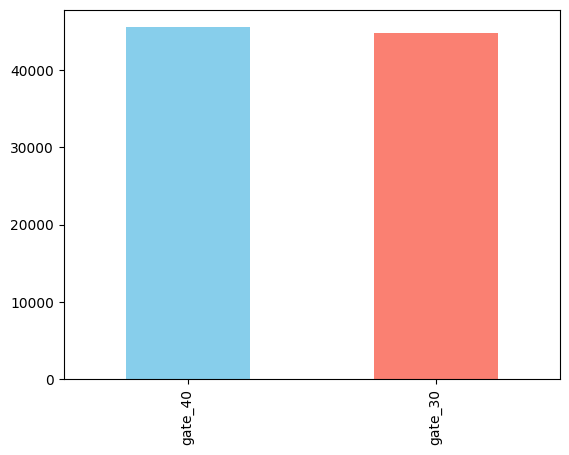

In [21]:
df['version'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

It seems that we have an approximately even distribution with both our groups. Nice!

\
Now let's find out if there's any outlier in our dataset that may potentially affect our testing. Since 'sum_gamerounds' is our only numerical variable, we'll focus on that one

<Axes: >

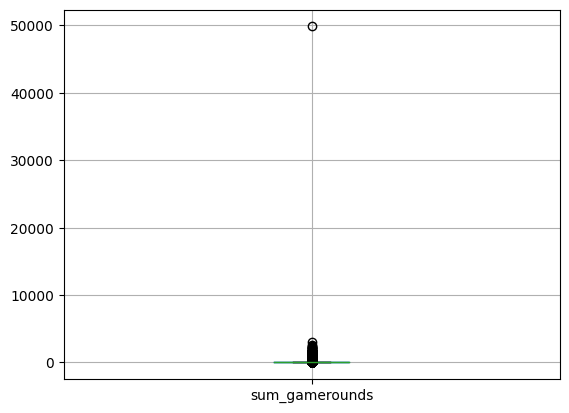

In [22]:
df.boxplot('sum_gamerounds')

By the looks of our boxplot, we have a lot of outliers in the data. We even have a very interesting outlier where that certain player played around 50,000 gamerounds! Talk about dedication.

In [23]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

By looking at summary statistics, there is indeed a player that played around 50,000 rounds. Sheesh! We can also notice that we have a high standard deviation score of 195. This means that most of our data is about 195 units away from the mean. Basically, our data has great variance or its dispersed.

We can also take this opportunity to look at the quantiles. There is a player that installed the game, but didn't even played a single round 😢.
- 25% of players only played about 5 rounds
- 50% of players only played about 16 rounds, not even reaching the 30th level gate!
- 75% of players played about 51 rounds.

Let's check if there are other players that also didn't play a single round

In [24]:
df[df['sum_gamerounds']==0].count()

userid            3994
version           3994
sum_gamerounds    3994
retention_1       3994
retention_7       3994
dtype: int64

Almost 4,000 players installed the game, but didn't even played a single round. It's very interesting to know what drives the player to stop playing even without experiencing the gameplay first.
- Perhaps they didnt like the interface?
- Or maybe they just haven't started playing yet

Whatever the reason is for these players, it would be beneficial to know the reason behind it.

Now let's take a look at the 25% percentile. These are players that played about 5 rounds since installation

In [25]:
df[(df['sum_gamerounds'] <= 5) & (df['sum_gamerounds'] != 0)]

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
3,483,gate_40,1,False,False
7,1444,gate_40,2,False,False
10,1842,gate_40,3,False,True
19,2502,gate_40,1,False,False
...,...,...,...,...,...
90161,9996426,gate_30,5,True,False
90162,9996480,gate_40,4,False,False
90166,9996999,gate_30,3,False,False
90169,9997628,gate_40,3,False,False


More than 20,000 players played fewer than 6 rounds since installation. The motivations behind these numbers are different with those that had 0 game rounds.
- Maybe they got bored after playing 1-2 rounds
- They found another game
- They didn't like the gameplay

It would be very beneficial to find out why these players stopped playing the game very early on. This could help us with retaining our player base


\
Remember the boxplot earlier? While we already know that there are a lot of outliers based on the graph, it's quite hard to determine the exact number of outliers and which one they are. So, let's make use of scipy package and calculate the z-scores of each row

In [26]:
from scipy import stats

z_scores = stats.zscore(df['sum_gamerounds'])
outliers = df[abs(z_scores) > 3]
print(outliers)

        userid  version  sum_gamerounds  retention_1  retention_7
601      63617  gate_30             902         True         True
655      69927  gate_30            1906         True         True
865      97308  gate_30             798         True         True
1097    121303  gate_30            1374         True         True
1264    139072  gate_40             681        False         True
...        ...      ...             ...          ...          ...
88328  9791599  gate_40            2063         True         True
88354  9794383  gate_40             846         True         True
88590  9822327  gate_40             768         True         True
89719  9949589  gate_40             708         True         True
89921  9971042  gate_30             892         True         True

[425 rows x 5 columns]


So according to the z-score method, we have about 425 rows of outliers. The question is, what do we do with them? Do we remove them completely? It's difficult to determine whether these were bugs, malfunctions, etc.

Personally, I wouldn't remove these outliers because we're gonna lose a lot of information on the behavior of these players if we simply get rid of them. Also, some of these outliers do practically make sense as a gamer myself. There will always be players who are in it for the grind!

## Results of the experiment

Now that we've done our EDA and some player behavior analysis, let's now take a look at the results of our experiment. Let's start with 1-day retention.

In [27]:
player_retention = df.groupby('version')['retention_1']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

player_retention = player_retention.agg([np.mean, std_p, se_p])
player_retention.columns = ['player_retention', 'std_deviation', 'std_error']


player_retention.style.format('{:.3f}')

,player_retention,std_deviation,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


<ipython-input-28-59f332f27930>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=df['version'], y=df['retention_1'], ci=False)


Text(0, 0.5, 'Retained (proportion)')

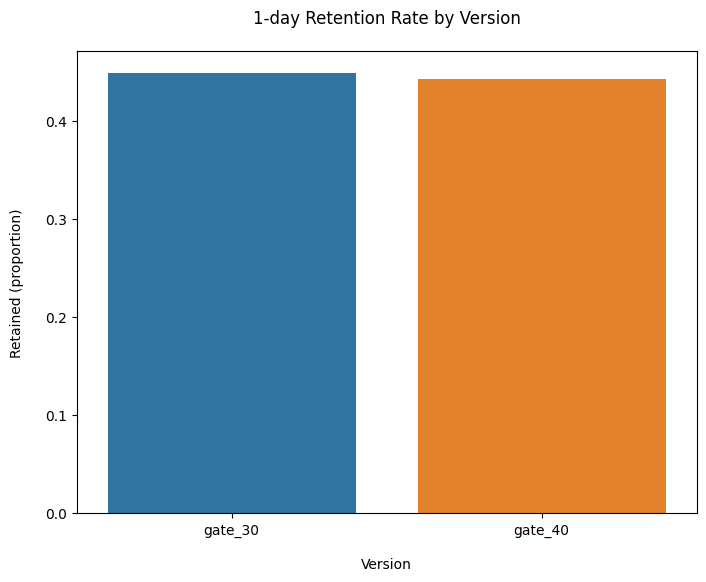

In [28]:
plt.figure(figsize=(8,6))

sns.barplot(x=df['version'], y=df['retention_1'], ci=False)

plt.title('1-day Retention Rate by Version', pad=20)
plt.xlabel('Version', labelpad=15)
plt.ylabel('Retained (proportion)', labelpad=15)

Judging by the stats above, it does look like our two levels performed very similarly, with our level 30 version performing slightly better, approx. 44.8% vs. 44.2% retention rate. That's about 0.6% difference

Looking past the difference, we can say that less than half of the players came back to the game after 1 day of installation. Its possible that they enjoyed the game when they first tried it out.

\
Let's now take a look at the 7-day retention. It makes sense for us to look at this too because since we are testing if level 30 or level 40 is the right level to place the gate, we need to consider that players wouldn't even reach that level after a day of installation.


In [29]:
player_retention = df.groupby('version')['retention_7']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

player_retention = player_retention.agg([np.mean, std_p, se_p])
player_retention.columns = ['player_retention', 'std_deviation', 'std_error']


player_retention.style.format('{:.3f}')

,player_retention,std_deviation,std_error
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


<ipython-input-30-9b6e7890164e>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=df['version'], y=df['retention_7'], ci=False)


Text(0, 0.5, 'Retained (proportion)')

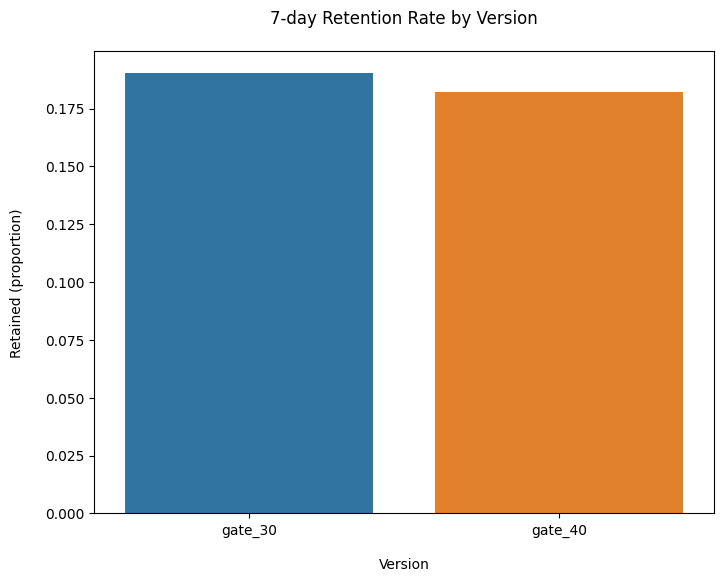

In [30]:
plt.figure(figsize=(8,6))

sns.barplot(x=df['version'], y=df['retention_7'], ci=False)

plt.title('7-day Retention Rate by Version', pad=20)
plt.xlabel('Version', labelpad=15)
plt.ylabel('Retained (proportion)', labelpad=15)

With the 7-day retention, we have a 0.8% difference with level 30 performing better than level 40, similary to the 1-day retention.

Another thing to notice here is that the retention rate for 7-day retention is lower than 1-day retention. This means that a significant amount of players stop playing after a week of installation.

\
Since level 30 is higher for both retention periods, does that mean it's better than level 40? We need to perform hypothesis testing in order to see that this didn't happen by random chance

\
## Hypothesis Testing

Since we know that our groups are normally distributed and we have large sample size (n>30), we can make use of z-test. A t-test can also work here since there is normality. I actually think there's no significant impact on the results if either use z-test or t-test. However, it is also worth noting that we have outliers! This could potentially affect our testing, and so we'll also try to use a non-parametric test, called the Mann-Whitney U test. This is a good alternative when dealing with outliers, as they are less sensitive to extreme values.

Let's first do the 1-day retention

In [31]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['version'] == 'gate_30']['retention_1']
treatment_results = df[df['version'] == 'gate_40']['retention_1']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.78
p-value: 0.074
ci 95% for control group: [0.444, 0.453]
ci 95% for treatment group: [0.438, 0.447]


Our p-value is greater than our alpha=0.05, so this means that we accept the null hypothesis and there is no statistical difference between level 30 and level 40 in terms of 1-day retention rate

Let's now try 7-day retention

In [32]:
control_results = df[df['version'] == 'gate_30']['retention_7']
treatment_results = df[df['version'] == 'gate_40']['retention_7']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 3.16
p-value: 0.002
ci 95% for control group: [0.187, 0.194]
ci 95% for treatment group: [0.178, 0.186]


Interestingly, our p-value is lower than our alpha. This means that we reject the null hypothesis, meaning that there is a statistical difference between the two groups when it comes to a 7-day retention.

Now what does this mean now? Since 1-day retention does show a greater average of retention rate for level 30, and the z-test proves that there is a statistical difference between level 30 and level 40 for 7-day retention, then we will stick with level 30 for now.

\
Now let's try doing it with Mann-Whiteney U Test to see if there's any change in the results

In [33]:
from scipy.stats import mannwhitneyu

In [34]:
control_results = df[df['version'] == 'gate_30']['retention_1']
treatment_results = df[df['version'] == 'gate_40']['retention_1']
test_stat, pvalue = mannwhitneyu(control_results,
                                 treatment_results)
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1022682813.0000, p-value = 0.0744


In [35]:
control_results = df[df['version'] == 'gate_30']['retention_7']
treatment_results = df[df['version'] == 'gate_40']['retention_7']
test_stat, pvalue = mannwhitneyu(control_results,
                                 treatment_results)
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1025017239.0000, p-value = 0.0016


As we can see, the Mann-Whiteney U Test resulted with almost similar p-values with the Z-test


## Drawing Conclusions
Here's what we know so far:

1 - day retention:
- Level 30 yields a higher retention rate than level 40
- There is no statistical difference between the control and treatment group

7 - day retention:
- Level 30 yields a higher retention rate than level 40
- There is a statistical difference between the control and treatment group

In addition, if we look at the confidence intervals of our treatment groups for both 1-day and 7-day retention, it includes values that are relatively lower than the average retention rate.

Since we accepted the null hypothesis for 1-day retention, and we rejected the null hypothesis for 7-day retention, they both suggest that the company will have a slightly better player retention rate if they stick with Level 30 as the placement of the gate.

However, I do suggest that the company should focus more of their attention with the 7-day retention rather than 1-day retention, despite it having the higher retention rate. This is because the main idea behind this experiment is to see whether players are being retained depending on the gate placement, and by looking only at 1-day retention, it doesn't really give us that much insight since not a lot of players will even reach level 30 or level 40 after a day of installation.

Another thing that we need to focus on, is to why the retention rate is higher if we put the gate at Level 30? It's possible that if a player truly enjoys a certain game for a shorter period of time, and they are forced to stop playing due to a gate, they develop a sense of wanting to play more, thus retaining them.